Модель  бустинга

## Импорты библиотек

In [1]:
from develop.augmentation import aug_all
from develop.create_labels import create_labels
from develop.score import trade

import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from sqlalchemy import create_engine, Column, Integer, String, TIMESTAMP, ARRAY
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from catboost import CatBoostRegressor
from catboost import CatBoostClassifier

from lightgbm import LGBMRegressor, LGBMClassifier


pd.set_option("display.max_columns", None)

## Константы

In [2]:
PAIRS_NAME = ['bnb_btc', 'eth_btc', 'bnb_eth','btc_usdt','eth_usdt','bnb_usdt']
LABELS_NAME = [
    'label',
    'bnb_btc_min',
    'bnb_btc_max',
    'bnb_btc_min_max',
    'eth_btc_min',
    'eth_btc_max',
    'eth_btc_min_max',
    'bnb_eth_min',
    'bnb_eth_max',
    'bnb_eth_min_max',
    'not_buy']

## Чтение данных

In [3]:
def config(service):
    with open('develop/config_connect.json', 'r') as f:
        config = json.load(f)
    if service == 'binance':
        config = config['binance']
    if service == 'postgres':
        config = config['postgres']

    return config

def config_model():
    with open('develop/config_model.json', 'r') as f:
        config_model = json.load(f)
    random = config_model['RANDOM']
    image_length = config_model['IMAGE_LENGTH']
    features_length = config_model['FEATURES_LENGTH']
    batch_size = config_model['BATCH_SIZE']
    epoch = config_model['EPOCH']
    fee = config_model['FEE']
    slip_n = config_model['SLIP_N']

    return random, image_length, features_length, batch_size, epoch, fee, slip_n

RANDOM, IMAGE_LENGTH, FEATURES_LENGTH, BATCH_SIZE, EPOCH, FEE, SLIP_N = config_model()

config_bin_dev = config('postgres')['binance']
engine = create_engine(f"postgresql+psycopg2://"
                       f"{config_bin_dev['user_name']}:"
                       f"{config_bin_dev['password']}@"
                       f"{config_bin_dev['server']}/"
                       f"{config_bin_dev['base_name']}")

ticker_price = pd.read_sql_table(table_name='ticker_price',
                                    con=engine,
                                    schema='public',
                                    index_col='id_ticker',
                                    columns=PAIRS_NAME)
ticker_price = ticker_price.astype('float')
ticker_price = ticker_price.sort_index()

In [4]:
DEPTH = 10 # глубина стакана
FEATURES_LENGTH = 10 # длинна феатурес

In [5]:
%%time

for table in ['bnb_btc_depth', 'bnb_eth_depth', 'eth_btc_depth', 'bnb_usdt_depth', 'btc_usdt_depth', 'eth_usdt_depth']:
    table_chunk = pd.read_sql_table(table_name=table,
                                      con=engine,
                                      schema='public',
                                      index_col='id_ticker',
                                      chunksize=1
                                     )
    
    table_list = list()

    for i, chunk in tqdm(enumerate(table_chunk)):
        data_df = pd.DataFrame(np.concatenate((np.array(chunk['bids'].iloc[0][:DEPTH])[:,1],
                                                               np.array(chunk['asks'].iloc[0][:DEPTH])[:,1])),
                                               columns = chunk.index).T.astype(float)
        table_list.append(data_df)
        if i == 100:
            break

    table_df = pd.concat(table_list).sort_index()
    np.save('features/'+table+'_10_scaler', table_df, allow_pickle=True, fix_imports=True)
    del table_chunk, table_list, table_df

100it [00:00, 774.14it/s]
100it [00:00, 799.94it/s]
100it [00:00, 806.63it/s]
100it [00:00, 793.18it/s]
100it [00:00, 797.77it/s]
100it [00:00, 797.07it/s]


CPU times: total: 37.6 s
Wall time: 4min 21s


In [8]:
data_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
id_ticker,,,,,,,,,,,,,,,,,,,,
100,6.3811,32.5267,32.0,2.6298,0.1767,0.678,1.2832,14.6437,1.217,1.075,8.2795,27.6038,0.028,0.1,0.08,0.1,0.6392,0.03,6.3411,0.7349


In [13]:
%%time

for table in ['bnb_btc_depth', 'bnb_eth_depth', 'eth_btc_depth', 'bnb_usdt_depth', 'btc_usdt_depth', 'eth_usdt_depth']:
    table_chunk = pd.read_sql_table(table_name=table,
                                      con=engine,
                                      schema='public',
                                      index_col='id_ticker',
                                      chunksize=1
                                     )
    
    table_list = list()

    for i, chunk in tqdm(enumerate(table_chunk)):
        table_list.append(pd.DataFrame(np.concatenate((np.array(chunk['bids'].iloc[0][:DEPTH])[:,1],
                                                               np.array(chunk['asks'].iloc[0][:DEPTH])[:,1])),
                                               columns = chunk.index).T.astype(float))

    table_df = pd.concat(table_list).sort_index()
    np.save('features/'+table+'_10_scaler', table_df, allow_pickle=True, fix_imports=True)
    del table_chunk, table_list, table_df

1057106it [23:11, 759.55it/s]
1057350it [23:45, 741.93it/s]
1057598it [23:55, 736.72it/s]
1057839it [23:49, 739.83it/s]
1058081it [23:31, 749.75it/s]
1058319it [23:41, 744.77it/s]


CPU times: total: 2h 27min 17s
Wall time: 2h 30min 51s


In [10]:
bnb_btc_depth = np.load('features/bnb_btc_depth_10_scaler.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
bnb_eth_depth = np.load('features/bnb_eth_depth_10_scaler.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
eth_btc_depth = np.load('features/eth_btc_depth_10_scaler.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
bnb_usdt_depth = np.load('features/bnb_usdt_depth_10_scaler.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
btc_usdt_depth = np.load('features/btc_usdt_depth_10_scaler.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
eth_usdt_depth = np.load('features/eth_usdt_depth_10_scaler.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [11]:
bnb_btc_depth.shape

(101, 20)

In [6]:
display(ticker_price.info())
#display(bnb_btc_24hr.info())
print(bnb_btc_depth.shape)
print(bnb_eth_depth.shape)
print(eth_btc_depth.shape)
print(bnb_usdt_depth.shape)
print(btc_usdt_depth.shape)
print(eth_usdt_depth.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1056148 entries, 1 to 1056148
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   bnb_btc   1056148 non-null  float64
 1   eth_btc   1056148 non-null  float64
 2   bnb_eth   1056148 non-null  float64
 3   btc_usdt  1056148 non-null  float64
 4   eth_usdt  1056148 non-null  float64
 5   bnb_usdt  1056148 non-null  float64
dtypes: float64(6)
memory usage: 56.4 MB


None

NameError: name 'bnb_btc_depth' is not defined

### Выравнивание таблиц по размеру наименьшей таблицы

In [7]:
tables_len = min([ticker_price.shape[0],
                  bnb_btc_depth.shape[0],
                  bnb_eth_depth.shape[0],
                  eth_btc_depth.shape[0],
                  bnb_usdt_depth.shape[0],
                  btc_usdt_depth.shape[0],
                  eth_usdt_depth.shape[0]])

ticker_price = ticker_price[:tables_len]
bnb_btc_depth = bnb_btc_depth[:tables_len]
bnb_eth_depth = bnb_eth_depth[:tables_len]
eth_btc_depth = eth_btc_depth[:tables_len]
bnb_usdt_depth = bnb_usdt_depth[:tables_len]
btc_usdt_depth = btc_usdt_depth[:tables_len]
eth_usdt_depth = eth_usdt_depth[:tables_len]

## Создание выборок

### Выделение валидационной выборки

In [8]:
(ticker_price, ticker_price_valid,
 bnb_btc_depth, bnb_btc_depth_valid,
 bnb_eth_depth, bnb_eth_depth_valid,
 eth_btc_depth, eth_btc_depth_valid,
 bnb_usdt_depth, bnb_usdt_depth_valid,
 btc_usdt_depth, btc_usdt_depth_valid,
 eth_usdt_depth, eth_usdt_depth_valid) = train_test_split(ticker_price,
                                                          bnb_btc_depth,
                                                          bnb_eth_depth,
                                                          eth_btc_depth,
                                                          bnb_usdt_depth,
                                                          btc_usdt_depth,
                                                          eth_usdt_depth,
                                                          test_size=0.50, random_state=RANDOM, shuffle=False)

In [9]:
(ticker_price.shape, 
 bnb_btc_depth.shape, 
 bnb_eth_depth.shape, 
 eth_btc_depth.shape, 
 bnb_usdt_depth.shape, 
 btc_usdt_depth.shape, 
 eth_usdt_depth.shape)

((350000, 6),
 (350000, 20),
 (350000, 20),
 (350000, 20),
 (350000, 20),
 (350000, 20),
 (350000, 20))

In [10]:
(ticker_price_valid.shape, 
 bnb_btc_depth_valid.shape, 
 bnb_eth_depth_valid.shape, 
 eth_btc_depth_valid.shape, 
 bnb_usdt_depth_valid.shape, 
 btc_usdt_depth_valid.shape, 
 eth_usdt_depth_valid.shape)

((350001, 6),
 (350001, 20),
 (350001, 20),
 (350001, 20),
 (350001, 20),
 (350001, 20),
 (350001, 20))

## Создание признаков

### Обучающая выборка

#### Создание labels

In [11]:
labels = create_labels(ticker_price, FEE, SLIP_N)
labels = labels['label'].values

ticker_price = ticker_price[PAIRS_NAME]

350000it [00:00, 2235684.60it/s]
C:\Users\denis\binance\develop\create_labels.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_max[pair_name + '_max'] = 1
C:\Users\denis\binance\develop\create_labels.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_min[pair_name + '_min'] = 1
350000it [00:00, 2219637.96it/s]
C:\Users\denis\binance\develop\create_labels.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

#### Создание targets
Дельта роста цены.

In [12]:
targets = (ticker_price[['bnb_btc','eth_btc','bnb_eth']].shift(-1) - ticker_price[['bnb_btc','eth_btc','bnb_eth']]) * 100_000 / ticker_price[['bnb_btc','eth_btc','bnb_eth']]

In [13]:
targets.shape

(350000, 3)

#### Создание features

Стандартизация стакана.

In [14]:
scaler_bnb_btc_depth = StandardScaler()
bnb_btc_depth_scaled = scaler_bnb_btc_depth.fit_transform(bnb_btc_depth)

scaler_bnb_eth_depth = StandardScaler()
bnb_eth_depth_scaled = scaler_bnb_eth_depth.fit_transform(bnb_eth_depth)

scaler_eth_btc_depth = StandardScaler()
eth_btc_depth_scaled = scaler_eth_btc_depth.fit_transform(eth_btc_depth)

scaler_bnb_usdt_depth = StandardScaler()
bnb_usdt_depth_scaled = scaler_bnb_usdt_depth.fit_transform(bnb_usdt_depth)

scaler_btc_usdt_depth = StandardScaler()
btc_usdt_depth_scaled = scaler_btc_usdt_depth.fit_transform(btc_usdt_depth)

scaler_eth_usdt_depth = StandardScaler()
eth_usdt_depth_scaled = scaler_eth_usdt_depth.fit_transform(eth_usdt_depth)

Объединение стакана.

In [15]:
depth_scaled = np.concatenate((bnb_btc_depth_scaled,
                             bnb_eth_depth_scaled, 
                             eth_btc_depth_scaled,
                             bnb_usdt_depth_scaled,
                             btc_usdt_depth_scaled,
                             eth_usdt_depth_scaled), axis=1)

del bnb_btc_depth_scaled, bnb_eth_depth_scaled, eth_btc_depth_scaled, bnb_usdt_depth_scaled, btc_usdt_depth_scaled, eth_usdt_depth_scaled
depth_scaled.shape

(350000, 120)

Дельта масштабированная.

In [16]:
ticker_price_delta_scaled = (ticker_price - ticker_price.shift(1)) * 100_000 / ticker_price

In [17]:
ticker_price_features_list = list()

for i in tqdm(range(FEATURES_LENGTH, ticker_price_delta_scaled.shape[0])):
    
    feature = ticker_price_delta_scaled.iloc[i-FEATURES_LENGTH+1:i+1].values.flatten() # .iloc невключая i

    
    ticker_price_features_list.append(feature)


ticker_price_features = np.array(ticker_price_features_list)

del ticker_price_features_list, ticker_price_delta_scaled, feature

100%|███████████████████████████████████████████████████████████████████████| 349990/349990 [00:08<00:00, 41753.34it/s]


In [18]:
depth_scaled = depth_scaled[FEATURES_LENGTH:]
labels = labels[FEATURES_LENGTH:]
targets = targets[FEATURES_LENGTH:]
ticker_price = ticker_price[FEATURES_LENGTH:]

Объединение признаков.

In [19]:
features = np.concatenate((ticker_price_features, depth_scaled), axis=1)
del ticker_price_features, depth_scaled
features.shape

(349990, 180)

Уадление последней строки с NaN  в targets.

In [20]:
features = features[:-1]
labels = labels[:-1]
targets = targets[:-1]
ticker_price = ticker_price[:-1]

### Валидационная выборка

#### Создание labels

In [21]:
ticker_price_valid['id_ticker'] = range(1,ticker_price_valid.shape[0]+1)
ticker_price_valid = ticker_price_valid.set_index('id_ticker')

labels_valid = create_labels(ticker_price_valid, FEE, SLIP_N)['label'].values

ticker_price_valid = ticker_price_valid[PAIRS_NAME]

350001it [00:00, 2389176.84it/s]
C:\Users\denis\binance\develop\create_labels.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_max[pair_name + '_max'] = 1
C:\Users\denis\binance\develop\create_labels.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_min[pair_name + '_min'] = 1
350001it [00:00, 2272135.12it/s]
C:\Users\denis\binance\develop\create_labels.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

#### Создание targets

Дельта роста цены.

In [22]:
targets_valid = (ticker_price_valid[['bnb_btc','eth_btc','bnb_eth']].shift(-1) - ticker_price_valid[['bnb_btc','eth_btc','bnb_eth']]) * 100_000 / ticker_price_valid[['bnb_btc','eth_btc','bnb_eth']]

In [23]:
targets_valid.shape

(350001, 3)

#### Создание features

Стандартизация стакана.

In [24]:
bnb_btc_depth_scaled_valid = scaler_bnb_btc_depth.transform(bnb_btc_depth_valid)

bnb_eth_depth_scaled_valid = scaler_bnb_eth_depth.transform(bnb_eth_depth_valid)

eth_btc_depth_scaled_valid = scaler_eth_btc_depth.transform(eth_btc_depth_valid)

bnb_usdt_depth_scaled_valid = scaler_bnb_usdt_depth.transform(bnb_usdt_depth_valid)

btc_usdt_depth_scaled_valid = scaler_btc_usdt_depth.transform(btc_usdt_depth_valid)

eth_usdt_depth_scaled_valid = scaler_eth_usdt_depth.transform(eth_usdt_depth_valid)

Объединение стакана.

In [25]:
depth_scaled_valid = np.concatenate((bnb_btc_depth_scaled_valid,
                                     bnb_eth_depth_scaled_valid, 
                                     eth_btc_depth_scaled_valid,
                                     bnb_usdt_depth_scaled_valid,
                                     btc_usdt_depth_scaled_valid,
                                     eth_usdt_depth_scaled_valid), axis=1)

del bnb_btc_depth_scaled_valid, bnb_eth_depth_scaled_valid, eth_btc_depth_scaled_valid, bnb_usdt_depth_scaled_valid, btc_usdt_depth_scaled_valid, eth_usdt_depth_scaled_valid
depth_scaled_valid.shape

(350001, 120)

Дельта масштабированная.

In [26]:
ticker_price_delta_scaled_valid = (ticker_price_valid - ticker_price_valid.shift(1)) * 100_000 / ticker_price_valid

In [27]:
ticker_price_features_list_valid = list()

for i in tqdm(range(FEATURES_LENGTH, ticker_price_delta_scaled_valid.shape[0])):
    
    feature = ticker_price_delta_scaled_valid.iloc[i-FEATURES_LENGTH+1:i+1].values.flatten() # .iloc невключая i

    
    ticker_price_features_list_valid.append(feature)


ticker_price_features_valid = np.array(ticker_price_features_list_valid)

del ticker_price_features_list_valid, ticker_price_delta_scaled_valid, feature

100%|███████████████████████████████████████████████████████████████████████| 349991/349991 [00:08<00:00, 41600.47it/s]


In [28]:
depth_scaled_valid = depth_scaled_valid[FEATURES_LENGTH:]
labels_valid = labels_valid[FEATURES_LENGTH:]
targets_valid = targets_valid[FEATURES_LENGTH:]
ticker_price_valid = ticker_price_valid[FEATURES_LENGTH:]

Объединение признаков.

In [29]:
features_valid = np.concatenate((ticker_price_features_valid, depth_scaled_valid), axis=1)

del ticker_price_features_valid, depth_scaled_valid
features_valid.shape

(349991, 180)

Уадление последней строки с NaN  в targets.

In [30]:
features_valid = features_valid[:-1]
labels_valid = labels_valid[:-1]
targets_valid = targets_valid[:-1]
ticker_price_valid = ticker_price_valid[:-1]

## Загрузчик данных

### Дисбаланс целевой функции для классификации

In [31]:
values, counts = np.unique(labels, return_counts=True)
print(values, counts)

[0 1 2 3 4 5 6] [347429    461    465    261    257    562    554]


In [32]:
i, = np.where(labels == 1)
features_1 = features[i]
labels_1 = labels[i]
i, = np.where(labels == 2)
features_2 = features[i]
labels_2 = labels[i]
i, = np.where(labels == 3)
features_3 = features[i]
labels_3 = labels[i]
i, = np.where(labels == 4)
features_4 = features[i]
labels_4 = labels[i]
i, = np.where(labels == 5)
features_5 = features[i]
labels_5 = labels[i]
i, = np.where(labels == 6)
features_6 = features[i]
labels_6 = labels[i]


for i in tqdm(range(5)):
   
 #    features = np.concatenate((features, features_3, features_4), axis=0)
 #    labels = np.concatenate((labels, labels_3, labels_4), axis=0)
    features = np.concatenate((features, features_1, features_2, features_3, features_3, features_4, features_4, features_5, features_6), axis=0)
    labels = np.concatenate((labels, labels_1, labels_2, labels_3, labels_3, labels_4, labels_4, labels_5, labels_6), axis=0)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


In [33]:
values, counts = np.unique(labels, return_counts=True)
print(values, counts)

[0 1 2 3 4 5 6] [347429   2766   2790   2871   2827   3372   3324]


In [34]:
features.shape, targets.shape, labels.shape

((365379, 180), (349989, 3), (365379,))

In [35]:
print(f'features memory usage {(features.nbytes/1_000_000_000):.1f} GB')

features memory usage 0.5 GB


### Перемешивание признаков

In [36]:
for i in tqdm(range (2)):
    features, labels = shuffle(features, labels, random_state=RANDOM*i)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.38it/s]


### DataLoader

#### train

#### valid

## Обрезка выборок для ускорения

In [37]:
abs(targets).mean()

bnb_btc    11.113691
eth_btc     7.509982
bnb_eth    13.810872
dtype: float64

In [38]:
abs(targets_valid).mean()

bnb_btc    8.127511
eth_btc    3.163396
bnb_eth    9.839535
dtype: float64

## Модель линейной регрессии c L1-регуляризацией (Lasso)

### bnb_btc

## Модель линейной регрессии c L2-регуляризацией (Ridge)

### bnb_btc

## Случайный лес RandomForest

### bnb_btc

### eth_btc

### bnb_eth

## Модель CatBoostRegressor CPU

### bnb_btc

### GPU

### eth_btc

### bnb_eth

## Модель LGBMRegressor CPU

### bnb_btc

### GPU

### eth_btc

### bnb_eth

## LogisticRegression

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\denis\anaconda3\envs\python_3_10_4_torch\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
C: 1.0
Traid counts: 1237 1: 175 2: 104 3: 132 4: 97 5: 560 6: 169
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    348690
           1       0.17      0.10      0.13       278
           2       0.18      0.07      0.10       270
           3       0.05      0.07      0.05        90
           4       0.05      0.05      0.05        91
           5       0.06      0.12      0.08       286
           6       0.18      0.11      0.14       285

    accuracy                           0.99    349990
   macro avg       0.24      0.22      0.22    349990
weighted avg       0.99      0.99      0.99    349990

-------------
SLIP_N = 1
Без торгов за счёт изменения курса с 300 usdt: 284.01171897876463
Результат торгов с 300 usdt: 316.33394486879587
Прибыль от 300 usdt за 100_000 тиков: 4.666974733219768
 


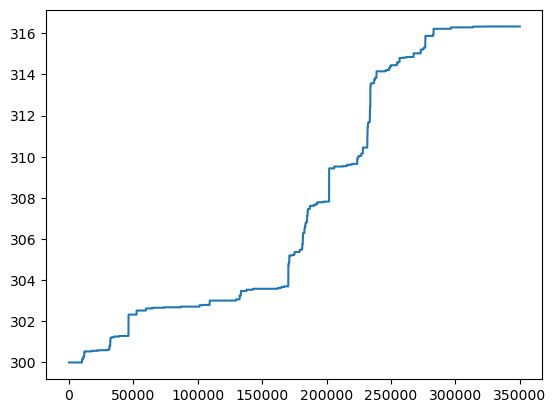

-------------
SLIP_N = 2
Без торгов за счёт изменения курса с 300 usdt: 284.01171897876463
Результат торгов с 300 usdt: 306.22137622017385
Прибыль от 300 usdt за 100_000 тиков: 1.7775868511025608
 


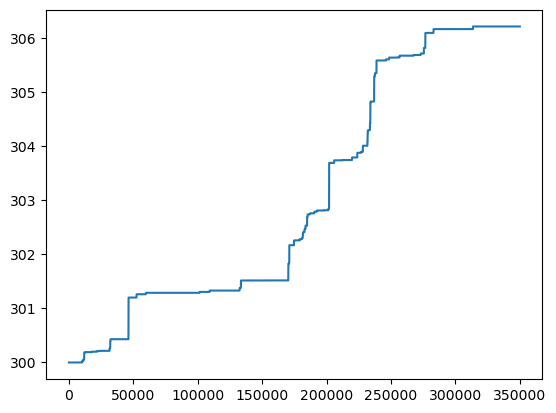

-------------
SLIP_N = 3
Без торгов за счёт изменения курса с 300 usdt: 284.01171897876463
Результат торгов с 300 usdt: 302.1201699685495
Прибыль от 300 usdt за 100_000 тиков: 0.6057801561614549
 


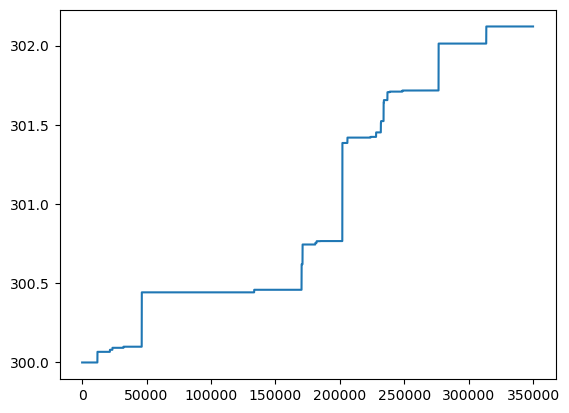

-------------
SLIP_N = 4
Без торгов за счёт изменения курса с 300 usdt: 284.01171897876463
Результат торгов с 300 usdt: 301.15131573425657
Прибыль от 300 usdt за 100_000 тиков: 0.32895675140906044
 


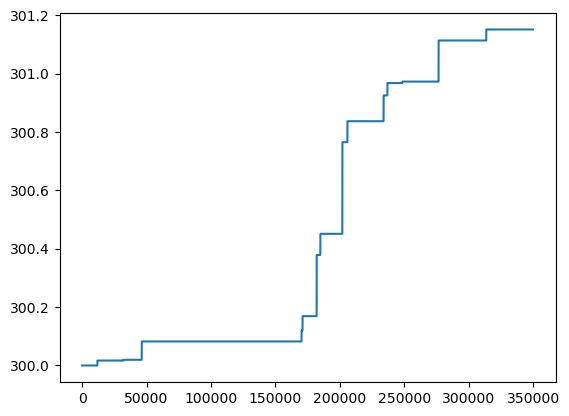

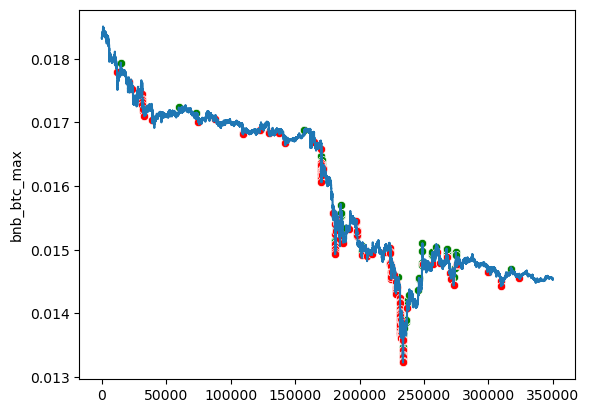

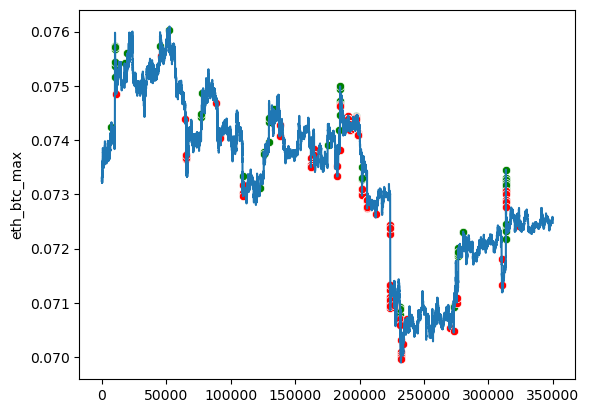

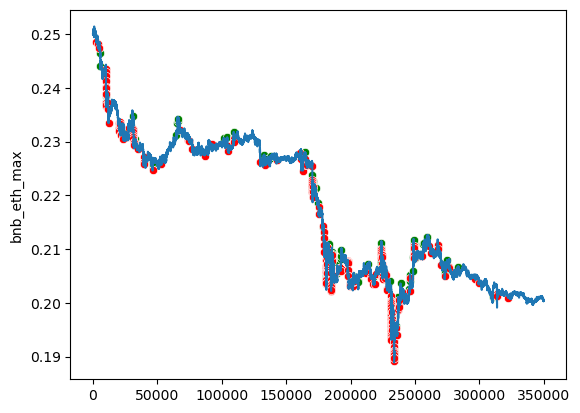

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:52<00:00, 52.97s/it]

CPU times: total: 2min 41s
Wall time: 53 s


In [39]:
%%time

C_list = list()
traid_counts_list = list()
profit_300_1_list = list()
profit_300_2_list = list()
profit_300_3_list = list()
profit_300_4_list = list()

ticker_price_valid_values = ticker_price_valid.values
ticker_price_valid_fig = ticker_price_valid

for C in tqdm(range(10,11)):
    model_LR = LogisticRegression(C=C/10, solver='lbfgs', multi_class='auto', random_state=RANDOM)
    model_LR.fit(features, labels)
    
    print('---***---***---***---***---***---***---***---***---***---***---***---***---')
    print('Predict start')
    predict = model_LR.predict(features_valid)

    print(f'C: {C/10}')
    C_list.append(C/10)
    
    traid_counts = (predict!=0).sum()
    traid_counts_list.append(traid_counts)
    print(f'Traid counts: {traid_counts}',
          f'1: {(predict==1).sum()}',
          f'2: {(predict==2).sum()}',
          f'3: {(predict==3).sum()}',
          f'4: {(predict==4).sum()}',
          f'5: {(predict==5).sum()}',
          f'6: {(predict==6).sum()}'
         )
    print(classification_report(labels_valid, predict))

    for slip_n in range(1,5):
        print("-------------")
        print(f'SLIP_N = {slip_n}')
        trade_result, volume_not_trade = trade(ticker_price_valid.values, predict, FEE, slip_n)
        trade_result = np.array(trade_result)
        print(f'Без торгов за счёт изменения курса с 300 usdt: {volume_not_trade}')
        print(f'Результат торгов с 300 usdt: {trade_result[-1]}')
        profit_300 = (trade_result[-1]-300)*100_000/predict.shape[0]
        if slip_n == 1:
            profit_300_1_list.append(profit_300)
        elif slip_n == 2:
            profit_300_2_list.append(profit_300)
        elif slip_n == 3:
            profit_300_3_list.append(profit_300)
        elif slip_n == 4:
            profit_300_4_list.append(profit_300)
        print(f'Прибыль от 300 usdt за 100_000 тиков: {profit_300}')
        print(' ')
        # отрисовка изменение объёма кошелька
        sns.lineplot(x=range(trade_result.shape[0]),y=trade_result)
        plt.show()
    
    # отрисовка сделок на тренде
    x_len = predict.shape[0]
      
    ticker_price_valid_fig[PAIRS_NAME[0]+'_min'] = ticker_price_valid_values[:,0]*(predict == 1)
    ticker_price_valid_fig[PAIRS_NAME[0]+'_max'] = ticker_price_valid_values[:,0]*(predict == 2)
    ticker_price_valid_fig[PAIRS_NAME[1]+'_min'] = ticker_price_valid_values[:,1]*(predict == 3)
    ticker_price_valid_fig[PAIRS_NAME[1]+'_max'] = ticker_price_valid_values[:,1]*(predict == 4)
    ticker_price_valid_fig[PAIRS_NAME[2]+'_min'] = ticker_price_valid_values[:,2]*(predict == 5)
    ticker_price_valid_fig[PAIRS_NAME[2]+'_max'] = ticker_price_valid_values[:,2]*(predict == 6)
    ticker_price_valid_fig = ticker_price_valid_fig.replace(0, np.nan)
        
    for i, pair in enumerate(['bnb_btc','eth_btc','bnb_eth']):
            
        fig, ax = plt.subplots()
        ax.plot(range(x_len),ticker_price_valid_values[:x_len,i])
        #ax.plot(range(x_len),trade_result['bnb_btc_max'][:x_len])
        sns.scatterplot(data=ticker_price_valid_fig[:x_len], x=range(x_len), y=pair+'_max', ax=ax, color='green')
        sns.scatterplot(data=ticker_price_valid_fig[:x_len], x=range(x_len), y=pair+'_min', ax=ax, color='red')
        #plt.ylim([ticker_price_valid_fig[pair+'_min'][:x_len].min(), ticker_price_valid_fig[pair+'_max'][:x_len].max()])
        plt.show()

trade_df = pd.DataFrame(data=[C_list, 
                              traid_counts_list, 
                              profit_300_1_list, 
                              profit_300_2_list, 
                              profit_300_3_list, 
                              profit_300_4_list]).T.rename(columns={0:'C',
                                                                     1:'traid_counts',
                                                                     2:'profit_300_1',
                                                                     3:'profit_300_2',
                                                                     4:'profit_300_3',
                                                                     5:'profit_300_4'})

In [40]:
trade_df

,C,traid_counts,profit_300_1,profit_300_2,profit_300_3,profit_300_4
0,1.0,1237.0,4.666975,1.777587,0.60578,0.328957


In [41]:
trade_df[trade_df['profit_300_1'] == trade_df['profit_300_1'].max()]

,C,traid_counts,profit_300_1,profit_300_2,profit_300_3,profit_300_4
0,1.0,1237.0,4.666975,1.777587,0.60578,0.328957


## LGBMClassifier

In [42]:
trade_df[trade_df['profit_300_1'] == trade_df['profit_300_1'].max()]

,C,traid_counts,profit_300_1,profit_300_2,profit_300_3,profit_300_4
0,1.0,1237.0,4.666975,1.777587,0.60578,0.328957


## Проверка модели при продаже на тестовых данных

### Предсказание на test

In [43]:
ticker_price_test.shape, ticker_test.shape, labels_test.shape

NameError: name 'ticker_price_test' is not defined

In [ ]:
X_scaled_test = list()
X_delta_maxmin_test = list()

#scaler = StandardScaler()
scaler_X_trend = MinMaxScaler()

for i in tqdm(range(FEATURES_LENGTH, ticker_price_test.shape[0])):
    
    X_trend_test = ticker_price_test.iloc[i-FEATURES_LENGTH:i] # .iloc невключая i
    X_delta_test = X_trend_test.max()-X_trend_test.min()
    X_delta_maxmin_test.append(X_delta_test)
    X_scaled_test.append(scaler_X_trend.fit_transform(X_trend_test).T)

X_scaled_test = np.array(X_scaled_test)
X_delta_maxmin_test = np.array(X_delta_maxmin_test)

In [ ]:
y_trend_test = labels_test['label'].iloc[FEATURES_LENGTH-1:-1].values
trend_test = ticker_price_test.iloc[FEATURES_LENGTH-1:-1].values

In [ ]:
X_scaled_test = X_scaled_test[:,:6,-IMAGE_LENGTH:]
X_scaled_test_tensor = torch.tensor(X_scaled_test.astype('float32'))

In [ ]:
predict_test = torch.argmax(res_net.to('cpu').inference(X_scaled_test_tensor), dim=1).detach().numpy()

### Предсказание на графике

In [ ]:
predict_test_fig = predict_test

In [ ]:
trade_result = ticker_test.iloc[FEATURES_LENGTH-1:-1]

In [ ]:
trade_result[PAIRS_NAME[0]+'_min'] = trend_test[:,0]*(predict_test_fig == 1)
trade_result[PAIRS_NAME[0]+'_max'] = trend_test[:,0]*(predict_test_fig == 2)
trade_result[PAIRS_NAME[1]+'_min'] = trend_test[:,1]*(predict_test_fig == 3)
trade_result[PAIRS_NAME[1]+'_max'] = trend_test[:,1]*(predict_test_fig == 4)
trade_result[PAIRS_NAME[2]+'_min'] = trend_test[:,2]*(predict_test_fig == 5)
trade_result[PAIRS_NAME[2]+'_max'] = trend_test[:,2]*(predict_test_fig == 6)

In [ ]:
trade_result = trade_result.replace(0, np.nan)

In [ ]:
x_len = 2000
pair = 'bnb_btc'

fig, ax = plt.subplots()
ax.plot(range(x_len),trend_test[:x_len,0])
#ax.plot(range(x_len),trade_result['bnb_btc_max'][:x_len])
sns.scatterplot(data=trade_result[:x_len], x=range(x_len), y=pair+'_max', ax=ax, color='green')
sns.scatterplot(data=trade_result[:x_len], x=range(x_len), y=pair+'_min', ax=ax, color='red')
plt.ylim([trade_result[pair+'_min'][:x_len].min(), trade_result[pair+'_max'][:x_len].max()])
plt.show()

In [ ]:
trade_result['bnb_eth_max'].sum() - trade_result['bnb_eth_min'].sum()

## Всякое

### Прибыль на валидационной выборке по разметке

In [ ]:
ticker_price

In [ ]:
labels['label'].values

In [ ]:
trade_result, volume_not_trade = trade(ticker_price.values, labels['label'].values, FEE, 1)
trade_result = np.array(trade_result)
print(f'Без торгов за счёт изменения курса с 300 usdt: {volume_not_trade}')
print(f'Результат торгов с 300 usdt: {trade_result[-1]}')
print(f'Прибыль от 300 usdt за 100_000 тиков: {(trade_result[-1]-300)*100_000/labels.shape[0]}')
sns.lineplot(x=range(trade_result.shape[0]),y=trade_result)
plt.show()